<a href="https://colab.research.google.com/github/guillemwilly/nn-zero-to-hero/blob/master/Persian_Girl_Names.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/dadashzadeh/persian-names/main/name-girl.txt

--2024-03-04 20:20:45--  https://raw.githubusercontent.com/dadashzadeh/persian-names/main/name-girl.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71755 (70K) [text/plain]
Saving to: ‘name-girl.txt’

name-girl.txt       100%[===================>]  70.07K  --.-KB/s    in 0.02s   

2024-03-04 20:20:46 (4.03 MB/s) - ‘name-girl.txt’ saved [71755/71755]



In [4]:
words = open('name-girl.txt', 'r').read().splitlines()
words[:8]

['فلور', 'دینه', 'پردیکا', 'الویرا', 'معینا', 'مهبان', 'چیلک', 'پویش']

In [5]:
len(words)

5548

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: ' ', 2: '(', 3: ')', 4: '2', 5: '3', 6: '،', 7: 'ء', 8: 'آ', 9: 'أ', 10: 'ؤ', 11: 'ئ', 12: 'ا', 13: 'ب', 14: 'ة', 15: 'ت', 16: 'ث', 17: 'ج', 18: 'ح', 19: 'خ', 20: 'د', 21: 'ذ', 22: 'ر', 23: 'ز', 24: 'س', 25: 'ش', 26: 'ص', 27: 'ض', 28: 'ط', 29: 'ظ', 30: 'ع', 31: 'غ', 32: 'ف', 33: 'ق', 34: 'ك', 35: 'ل', 36: 'م', 37: 'ن', 38: 'ه', 39: 'و', 40: 'ي', 41: 'َ', 42: 'ُ', 43: 'ِ', 44: 'ّ', 45: 'ْ', 46: 'ٔ', 47: 'پ', 48: 'چ', 49: 'ژ', 50: 'ک', 51: 'گ', 52: 'ی', 53: '\u200c', 0: '.'}


In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([28995, 3]) torch.Size([28995])
torch.Size([3611, 3]) torch.Size([3611])
torch.Size([3687, 3]) torch.Size([3687])


In [8]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((54, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 54), generator=g)
b2 = torch.randn(54, generator=g)
parameters = [C, W1, b1, W2, b2]

In [9]:
sum(p.nelement() for p in parameters) # number of parameters in total

17594

In [10]:
for p in parameters:
  p.requires_grad = True

In [11]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [12]:
lri = []
lossi = []
stepi = []

In [13]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 54)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

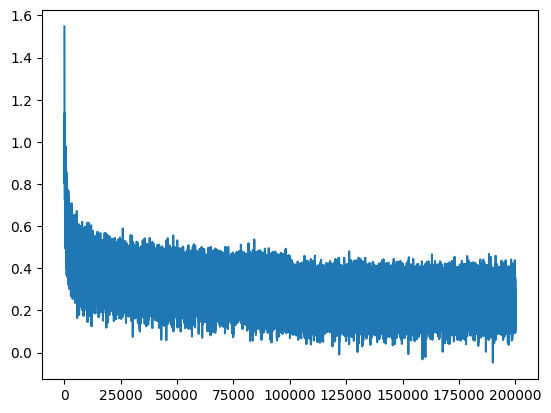

In [14]:
plt.plot(stepi, lossi)

In [37]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.8266, grad_fn=<NllLossBackward0>)

In [38]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4410, grad_fn=<NllLossBackward0>)

In [39]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.4735, grad_fn=<NllLossBackward0>)

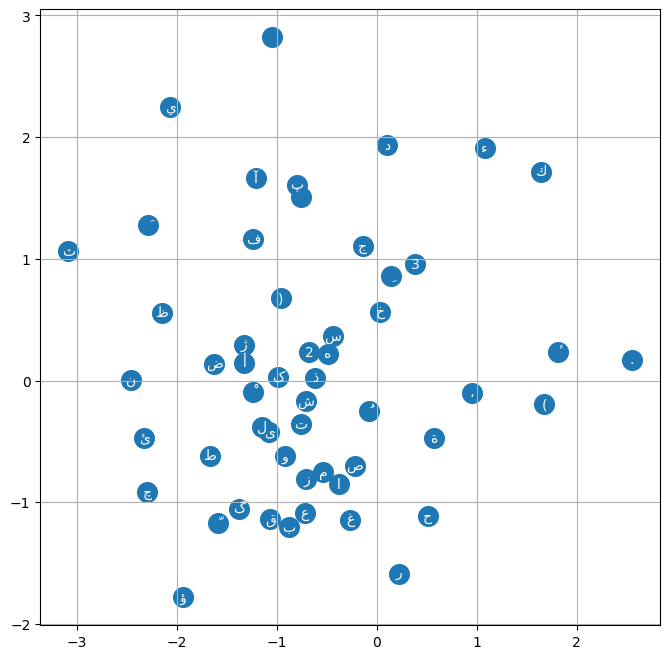

In [40]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [42]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(100):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

گلچهرچخن گل.
صدر.
کامیهانین.
گل خاتون.
ایل.
فرچهر.
بلار.
آفرین دا.
آوین.
مجین ناز.
چدا.
بژوفان.
شمس السا.
گران دخت.
وان.
زرارگل.
فرخ میه.
مهر آفریهش.
آذربوا.
گل مهر.
خرام بانوش.
میلالهه.
آنیتا.
ارک.
محبوه.
گره.
رورتاج.
ثمیل.
چلچلستاتین.
سرگل.
همایدا.
سرور.
حورا.
ویل.
تحکه.
رخشادروان.
ناد.
هادیا.
آلین.
گل بانده.
دلرینا.
رای.
بهار.
مین دخت.
آسیما.
روژه.
آنائله.
مایلادان.
هلز.
لیوانرینا.
نور الزمان.
تادخت.
پريبا.
لوویات.
مهدی.
شوخایه.
شیریار.
رُرنج.
زرخ.
صفورور.
چکان.
دلیله رخ.
افشان دخت.
تمنُ.
سند.
انگ.
فان.
نگار.
خزردآفریضه.
فخنّه.
زرانه فروز.
فته.
فیژا.
دل پنونگ.
پربه.
فان.
دُرفام.
آترین.
هایته.
چهره.
اشميما.
مان.
مهربخش.
توفا.
ناز.
آزرمیل.
الیالان.
عالین.
موناینا.
لیا.
نوش.
راواندخت.
نسی.
توسانا.
هور.
جنگک.
شروفه.
ماجاروینارگل.
آپام.
شهدیبارین نوش.
